# **IMPORT LIBRARY**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize as word_tokenize_wrapper
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud,STOPWORDS
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# **IMPORT DATA**

## **Read Data**

In [3]:
data = pd.read_csv("netflix_reviews.csv")
data.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,61a10e0d-e868-4d87-aa30-f41d30285a3f,badr mosa,Terrible app I can't watch anything because of...,1,0,8.121.2 build 22 50727,2024-07-08 15:41:17,8.121.2 build 22 50727
1,1a7ce341-afc6-46da-9d08-793582e8ed3c,Ivan Berry,"I love 💕💕 to download it,,😭",5,0,NaN,2024-07-07 17:47:19,NaN
2,1bd445c3-7f36-4717-810a-63c5533207d0,Ryan Murray,Exceptional,5,1,8.121.2 build 22 50727,2024-07-07 12:31:53,8.121.2 build 22 50727
3,59f306cd-852b-4459-b24f-3e4436df8465,Shannon Bonacci,Can't even make it through a full episode of a...,2,2,8.121.2 build 22 50727,2024-07-07 05:21:45,8.121.2 build 22 50727
4,f21a1d8a-2b4c-4385-8aff-ca317a00e032,Katie Hutchinson,Great,5,0,8.26.0 build 11 40221,2024-07-06 19:47:34,8.26.0 build 11 40221


## **Data Information**

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113620 entries, 0 to 113619
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              113620 non-null  object
 1   userName              113618 non-null  object
 2   content               113618 non-null  object
 3   score                 113620 non-null  int64 
 4   thumbsUpCount         113620 non-null  int64 
 5   reviewCreatedVersion  96981 non-null   object
 6   at                    113620 non-null  object
 7   appVersion            96981 non-null   object
dtypes: int64(2), object(6)
memory usage: 6.9+ MB


# **DATA PROCESSING**

The first step after importing data is to process the data. Data processing involves two things, i.e:
- Checking for missing values
- Checking for duplication in the data.

## **Data Cleaning**

### **Missing Value Check**

- Model Performance: Missing values can significantly affect the performance of machine learning models. In NLP, if parts of the text are missing, it could lead to **incomplete information** for **model training** and **predictions**.
- Bias: Missing data can introduce **bias**, leading to **incorrect conclusions** or **predictions**.

In [5]:
data.isnull().sum()

reviewId                    0
userName                    2
content                     2
score                       0
thumbsUpCount               0
reviewCreatedVersion    16639
at                          0
appVersion              16639
dtype: int64

In [6]:
data = data.dropna()
data.isnull().sum()

reviewId                0
userName                0
content                 0
score                   0
thumbsUpCount           0
reviewCreatedVersion    0
at                      0
appVersion              0
dtype: int64

### **Duplicate Value Check**

- Redundancy: Duplicate entries can lead to redundancy, causing the model to give more importance to repeated information.
- Bias: Duplication can skew the model’s understanding of the text, leading to overfitting or biased results.

In [7]:
data_duplicated = data.duplicated().sum()
data_duplicated

226

In [8]:
data = data.drop_duplicates()
data_duplicated = data.duplicated().sum()
data_duplicated

0

In [9]:
data.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,61a10e0d-e868-4d87-aa30-f41d30285a3f,badr mosa,Terrible app I can't watch anything because of...,1,0,8.121.2 build 22 50727,2024-07-08 15:41:17,8.121.2 build 22 50727
2,1bd445c3-7f36-4717-810a-63c5533207d0,Ryan Murray,Exceptional,5,1,8.121.2 build 22 50727,2024-07-07 12:31:53,8.121.2 build 22 50727
3,59f306cd-852b-4459-b24f-3e4436df8465,Shannon Bonacci,Can't even make it through a full episode of a...,2,2,8.121.2 build 22 50727,2024-07-07 05:21:45,8.121.2 build 22 50727
4,f21a1d8a-2b4c-4385-8aff-ca317a00e032,Katie Hutchinson,Great,5,0,8.26.0 build 11 40221,2024-07-06 19:47:34,8.26.0 build 11 40221
5,bdd267b4-4231-4a5d-b369-3ac9e5082fc5,Mirza Irfan,Your device is not part of the Netflix Househo...,1,0,8.120.0 build 10 50712,2024-07-05 17:09:39,8.120.0 build 10 50712


In [10]:
data['content'].head(10)

0     Terrible app I can't watch anything because of...
2                                           Exceptional
3     Can't even make it through a full episode of a...
4                                                 Great
5     Your device is not part of the Netflix Househo...
6     I've been trying to pay for a month since I cr...
7                                          Kayla Kwadau
8                                      Abdulrhamam Sekh
9                                                  Good
10    Plsssss stoppppp giving screen limit like when...
Name: content, dtype: object

# **TEXT PROCESSING**

In text processing, it is split into 6 steps sequentially, i.e:
- **Case Folding**
- **Cleaning**
- **Tokenizing**
- **Lemmatization**
- **Stop Removal**
- **Labeling**

## **Case Folding**

The first thing to do is case folding. Case folding is changing sentences that have **capital letters** into **lowercase letters**. This will have an impact on the results of the analysis.

In [11]:
def case_folding(text):
    # Convert to lowercase
    text = text.lower()
    return text

data['content'] = data['content'].apply(case_folding)
data['content'].head(10)

0     terrible app i can't watch anything because of...
2                                           exceptional
3     can't even make it through a full episode of a...
4                                                 great
5     your device is not part of the netflix househo...
6     i've been trying to pay for a month since i cr...
7                                          kayla kwadau
8                                      abdulrhamam sekh
9                                                  good
10    plsssss stoppppp giving screen limit like when...
Name: content, dtype: object

## **Cleaning**

Then perform data cleansing by removing extra punctuation, numbers, and spaces.

In [12]:
def cleaning(text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]|[\d]|_', '', text)
    # Remove number
    text = re.sub(r'\d+', '', text)
    # Remove spacing
    text = text.strip()
    return text

data['content'] = data['content'].apply(cleaning)
data['content'].head(10)

0     terrible app i cant watch anything because of ...
2                                           exceptional
3     cant even make it through a full episode of a ...
4                                                 great
5     your device is not part of the netflix househo...
6     ive been trying to pay for a month since i cre...
7                                          kayla kwadau
8                                      abdulrhamam sekh
9                                                  good
10    plsssss stoppppp giving screen limit like when...
Name: content, dtype: object

## **Tokenizing**

After the data have been cleaned, each sentence's words are transformed into **tokens** according to **spaces** or **punctuation signs**.

In [13]:
def tokenizing(text):
    # Tokenize
    tokens = word_tokenize(text)
    return tokens

data['content'] = data['content'].apply(tokenizing)
data['content'].head(10)

0     [terrible, app, i, cant, watch, anything, beca...
2                                         [exceptional]
3     [cant, even, make, it, through, a, full, episo...
4                                               [great]
5     [your, device, is, not, part, of, the, netflix...
6     [ive, been, trying, to, pay, for, a, month, si...
7                                       [kayla, kwadau]
8                                   [abdulrhamam, sekh]
9                                                [good]
10    [plsssss, stoppppp, giving, screen, limit, lik...
Name: content, dtype: object

## **Lemmatization**

This process involved reducing words to their **original words** or dictionary forms (lemma).

In [14]:
def lemmatization(text):
    # Initialize Lemmatizer
    lemmatizer = WordNetLemmatizer()
    # Lemmatize
    lemmatized_words = [lemmatizer.lemmatize(word) for word in text]
    return lemmatized_words

data['content'] = data['content'].apply(lemmatization)
data['content'].head(10)

0     [terrible, app, i, cant, watch, anything, beca...
2                                         [exceptional]
3     [cant, even, make, it, through, a, full, episo...
4                                               [great]
5     [your, device, is, not, part, of, the, netflix...
6     [ive, been, trying, to, pay, for, a, month, si...
7                                       [kayla, kwadau]
8                                   [abdulrhamam, sekh]
9                                                [good]
10    [plsssss, stoppppp, giving, screen, limit, lik...
Name: content, dtype: object

## **Stop Words Removal**

The process of removing meaningless words, like **articles**, **prepositions**, **conjunctions**, and **other words** that often appear but are not meaningful. This is to reduce the dimensionality of the data and focus only on meaningful words.

In [15]:
def stopword(text):
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in text if word not in stop_words]
    return filtered_words

data['content'] = data['content'].apply(stopword)
data['content'].head(10)

0     [terrible, app, cant, watch, anything, househo...
2                                         [exceptional]
3     [cant, even, make, full, episode, show, app, c...
4                                               [great]
5     [device, part, netflix, householde, good, poli...
6     [ive, trying, pay, month, since, created, acco...
7                                       [kayla, kwadau]
8                                   [abdulrhamam, sekh]
9                                                [good]
10    [plsssss, stoppppp, giving, screen, limit, lik...
Name: content, dtype: object

## **Labeling**

Automatic labeling of each word using the VADER Lexicon. Each word will be given a different sentiment score. In this case, each word will be categorized into 3 categories, i.e.:
- Positive, if the **compound value >= 0.05**
- Negative, if the **value -0.05 < compound < 0.05**
- Neutral, if the **compound value <= -0.05**

In [16]:
# Initialize Vader Analyzer
analyzer = SentimentIntensityAnalyzer()

In [17]:
# Function to get sentiment
def vader_sentiment(text):
    # Convert text to string if it's not already
    if isinstance(text, list):
        text = ' '.join(text)
    score = analyzer.polarity_scores(text)
    return score['compound']

In [18]:
# Function to label sentiment based on compound score
def vader_sentiment_label(compound):
    # Label sentiment
    if compound >= 0.05:
        return 'Positive'
    elif compound > -0.05 and compound < 0.05:
        return 'Neutral'
    else:
        return 'Negative'

In [19]:
data['vader_sentiment'] = data['content'].apply(vader_sentiment)
data['vader_sentiment_label'] = data['vader_sentiment'].apply(vader_sentiment_label)
data[['content', 'vader_sentiment', 'vader_sentiment_label']].head(10)

,content,vader_sentiment,vader_sentiment_label
0,"[terrible, app, cant, watch, anything, househo...",-0.6705,Negative
2,[exceptional],0.0000,Neutral
3,"[cant, even, make, full, episode, show, app, c...",-0.1280,Negative
4,[great],0.6249,Positive
5,"[device, part, netflix, householde, good, poli...",0.1779,Positive
6,"[ive, trying, pay, month, since, created, acco...",0.1531,Positive
7,"[kayla, kwadau]",0.0000,Neutral
8,"[abdulrhamam, sekh]",0.0000,Neutral
9,[good],0.4404,Positive
10,"[plsssss, stoppppp, giving, screen, limit, lik...",0.7269,Positive


Label encoding is a process used to **convert categorical labels** into **numeric** form so that they can be fed into machine learning models. In the context of NLP and sentiment analysis, label encoding is often used to convert text labels (like "Positive," "Negative," and "Neutral") into numerical values.

In [20]:
# Label Encoding
label_encoder = LabelEncoder()
data['vader_sentiment_label_encoded'] = label_encoder.fit_transform(data['vader_sentiment_label'])
data.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion,vader_sentiment,vader_sentiment_label,vader_sentiment_label_encoded
0,61a10e0d-e868-4d87-aa30-f41d30285a3f,badr mosa,"[terrible, app, cant, watch, anything, househo...",1,0,8.121.2 build 22 50727,2024-07-08 15:41:17,8.121.2 build 22 50727,-0.6705,Negative,0
2,1bd445c3-7f36-4717-810a-63c5533207d0,Ryan Murray,[exceptional],5,1,8.121.2 build 22 50727,2024-07-07 12:31:53,8.121.2 build 22 50727,0.0000,Neutral,1
3,59f306cd-852b-4459-b24f-3e4436df8465,Shannon Bonacci,"[cant, even, make, full, episode, show, app, c...",2,2,8.121.2 build 22 50727,2024-07-07 05:21:45,8.121.2 build 22 50727,-0.1280,Negative,0
4,f21a1d8a-2b4c-4385-8aff-ca317a00e032,Katie Hutchinson,[great],5,0,8.26.0 build 11 40221,2024-07-06 19:47:34,8.26.0 build 11 40221,0.6249,Positive,2
5,bdd267b4-4231-4a5d-b369-3ac9e5082fc5,Mirza Irfan,"[device, part, netflix, householde, good, poli...",1,0,8.120.0 build 10 50712,2024-07-05 17:09:39,8.120.0 build 10 50712,0.1779,Positive,2


# **EXPLORATORY DATA ANALYSIS**

### **Distribution of Score**

<ipython-input-22-7e4fb77df5fe>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="score", data=data, palette='Set3')


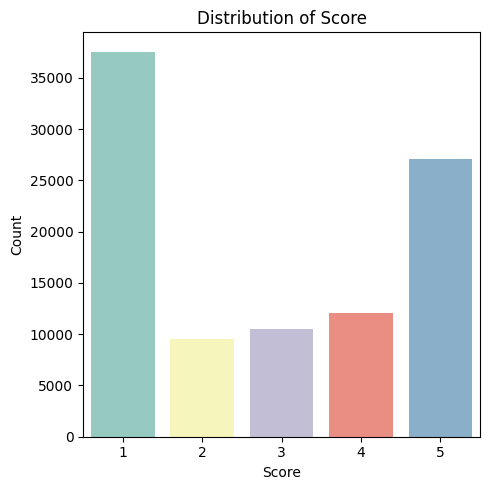

In [22]:
plt.figure(figsize=(5, 5))
sns.countplot(x="score", data=data, palette='Set3')
plt.title('Distribution of Score', fontsize=12)
plt.xlabel('Score')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## **Proportion of Sentiment**

Exploring labels to find out the sentiment proportion of each category

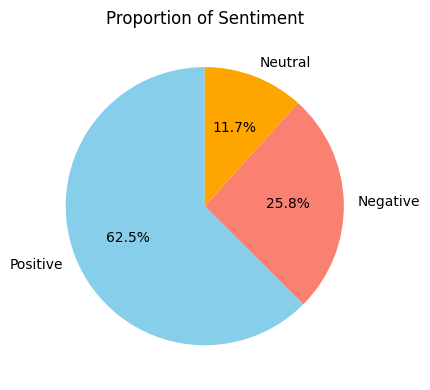

In [23]:
# Pie Chart
plt.figure(figsize=(8, 4))
data['vader_sentiment_label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon', 'orange'])
plt.title('Proportion of Sentiment', fontsize=12)
plt.ylabel('')
plt.tight_layout()
plt.show()

## **Word Cloud**

A word cloud helps in visualizing the most frequent words in the dataset. This can give an immediate sense of what the text data is about.

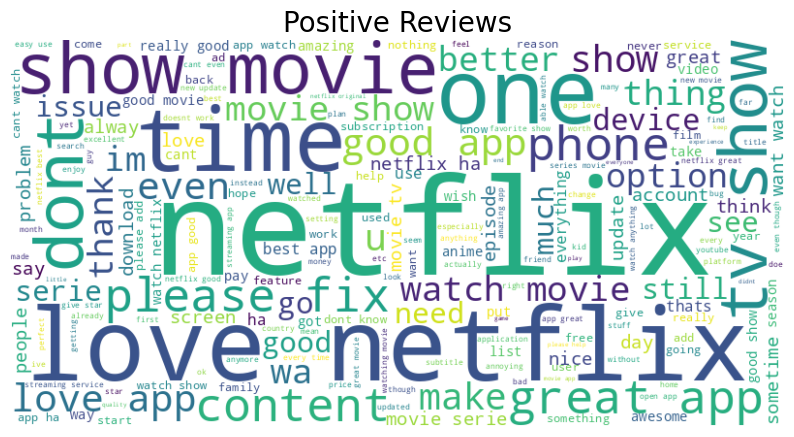

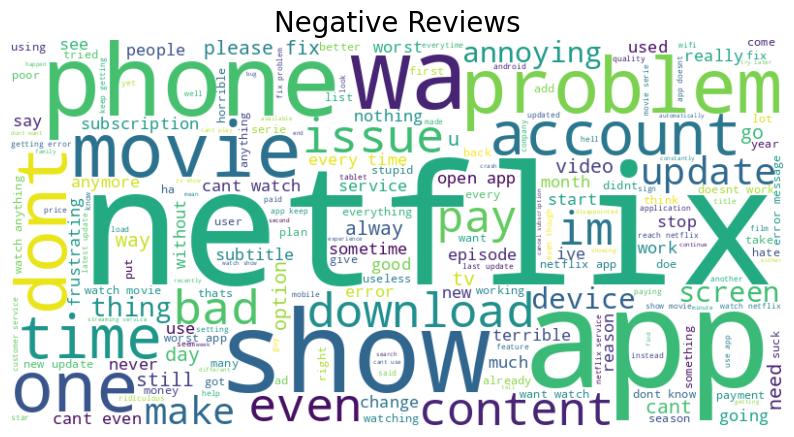

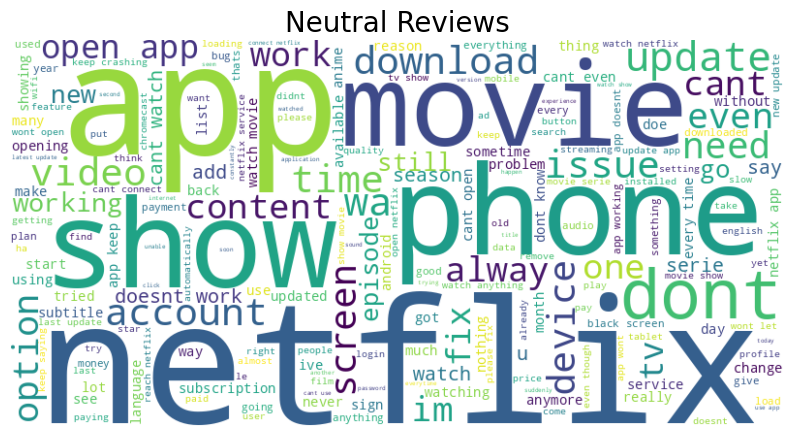

In [24]:
def create_wordcloud(text, title=None):
    # Join all text elements into a single string, handling potential lists within the Series
    all_text = " ".join( " ".join(text_item) if isinstance(text_item, list) else text_item for text_item in text)
    stop_words = set(STOPWORDS.union(set(stopwords.words('english'))))
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words).generate(all_text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    if title:
        plt.title(title, fontsize=20)
    plt.show()

# Create Word Clouds for each sentiment
positive_reviews = data[data['vader_sentiment_label'] == 'Positive']['content']
negative_reviews = data[data['vader_sentiment_label'] == 'Negative']['content']
neutral_reviews = data[data['vader_sentiment_label'] == 'Neutral']['content']

create_wordcloud(positive_reviews, "Positive Reviews")
create_wordcloud(negative_reviews, "Negative Reviews")
create_wordcloud(neutral_reviews, "Neutral Reviews")

# **FEATURE EXTRACTION**

## **CountVectorizer**

Extraction of features that **transform text** into a **matrix of token counts.** It counts the number of occurrences of each word in the document. In other words, it **converts text data** into a **numerical representation** for modeling.

In [25]:
# Function Vectorizer
def vectorizer(text):
    # Convert text to string if it's not already
    if isinstance(text[0], list):
        text = [' '.join(doc) for doc in text]

    # Initialize CountVectorizer
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(text)
    return X, vectorizer

In [26]:
X_counts, count_vectorizer = vectorizer(data['content'])

## **Change to TF-IDF**

It converts the **token count matrix** from CountVectorizer into **TF-IDF representation**. It not only considers the word frequency, but also how **unique** or **important** a word is in all documents.

In [27]:
# Function to change representation to TF-IDF
def tfidf_transformer(X_counts):
    # Initialize TF-IDF Transformer
    transformer = TfidfTransformer()
    X_tfidf = transformer.fit_transform(X_counts)
    return X_tfidf

# Inisialize TF-IDF
X_tfidf = tfidf_transformer(X_counts)
print("TF-IDF Shape:", X_tfidf.shape)

TF-IDF Shape: (96753, 41499)


# **SPLIT DATA**

Partitioned data into training data and testing data randomly. The training data is 80% of the total data, while the testing data is 20% of the overall data.

In [28]:
y = data['vader_sentiment_label_encoded']
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [29]:
print(X_train.toarray()[:5])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [30]:
print(X_test.toarray()[:5])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [31]:
print(y_train.head())

86258    2
97186    2
72919    1
32864    2
70266    2
Name: vader_sentiment_label_encoded, dtype: int64


In [32]:
print(y_test.head())

69627    2
50960    2
43295    1
46308    2
38955    0
Name: vader_sentiment_label_encoded, dtype: int64


# **MODELLING**

Machine learning modeling using **Multinomial Logistic Regression** and **Multinomial Naïve Bayes** algorithms

## **Multinomial Logistic Regression**

### **Build Model**

The **Stochastic Average Gradient Descent** (sag) optimization technique is used to minimize the cost function. This technique is suitable for **large data**.

The Basic Idea:
- Calculates the probability of each class (positive, negative, and neutral) using a softmax activation function. This activation function ensures that the total probability is 1
- Model coefficients are optimized using a 'sag' optimization technique that iteratively updates by considering the average gradient of the training data

In [36]:
# Build Model
model_mlg = LogisticRegression(multi_class='multinomial',
                               solver='sag')

### **Train Model**

In [38]:
# Train Model
model_mlg.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial', solver='sag')

In [39]:
# Weight (paramter model)
W = model_mlg.coef_
W

array([[ 0.25816663, -0.36095406, -0.02167254, ..., -0.03892174,
        -0.07016941, -0.03892174],
       [-0.16217176,  0.42427169, -0.01641691, ...,  0.08621145,
         0.15542212,  0.08621145],
       [-0.09599486, -0.06331763,  0.03808945, ..., -0.04728972,
        -0.08525271, -0.04728972]])

In [40]:
# Biases
b = model_mlg.intercept_
b

array([-0.45505287,  0.68520272, -0.23014986])

## **Naive Bayes Multinomial**

### **Build Model**

Multinomial Naïve Bayes algorithm is a commonly used algorithm for solving text processing cases.

Basic idea:
- The prediction of naive bayes requires that each conditional probability cannot be zero. To avoid this problem, an alpha parameter called Laplacian Smoothing/Correction can be set.
- The model learns the prior probability distribution which provides information about the parameter distribution. By setting fit_prior to True, the model will estimate the class odds from the training data.
- Similarly to alpha, force_alpha when set to True, alpha will be added when a feature does not appear in a particular class during training.

In [41]:
# Build Model
model_nbm = MultinomialNB(alpha = 1,
                          fit_prior = True,
                          force_alpha = True)

### **Train Model**

In [42]:
# Train Model
model_nbm.fit(X_train, y_train)

MultinomialNB(alpha=1, force_alpha=True)

# **MODEL EVALUATION**

The model was evaluated with several considerations, i.e:
- **Classification evaluation metrics**
- **AUC score**
- **Classification Report**

## **Multinomial Logistic Regression**

### **Predict**

The steps in making predictions are as follows:
- Calculate the linear combination between features and weights (parameters) added with bias.
- Using softmax activation function to get the probability of each class (positive, negative, and neutral).
- Calculating the loss function using "sag" to get the chance of class prediction.
- Update using gradient descent by iteration until converged.

In [43]:
# Predict
y_pred_mlg = model_mlg.predict(X_test)
y_pred_mlg

array([2, 2, 2, ..., 2, 2, 2])

### **Probability**

In [44]:
# Probability
y_prob_mlg = model_mlg.predict_proba(X_test)
print(y_prob_mlg)

[[0.00594467 0.0014336  0.99262173]
 [0.18248471 0.06359198 0.75392331]
 [0.30025604 0.33526774 0.36447623]
 ...
 [0.00175974 0.00242703 0.99581323]
 [0.06267737 0.06075612 0.8765665 ]
 [0.05154978 0.1192065  0.82924372]]


### **Evaluation Metric**

In [45]:
# Evaluation Metric
print(f'Accuracy: {accuracy_score(y_test, y_pred_mlg)}')
print(f'Precision: {precision_score(y_test, y_pred_mlg, average="weighted")}')
print(f'Recall: {recall_score(y_test, y_pred_mlg, average="weighted")}')
print(f'F1-Score: {f1_score(y_test, y_pred_mlg, average="weighted")}')

Accuracy: 0.8853289235698414
Precision: 0.8837216773271677
Recall: 0.8853289235698414
F1-Score: 0.88388566048376


### **Confusion Matrix**

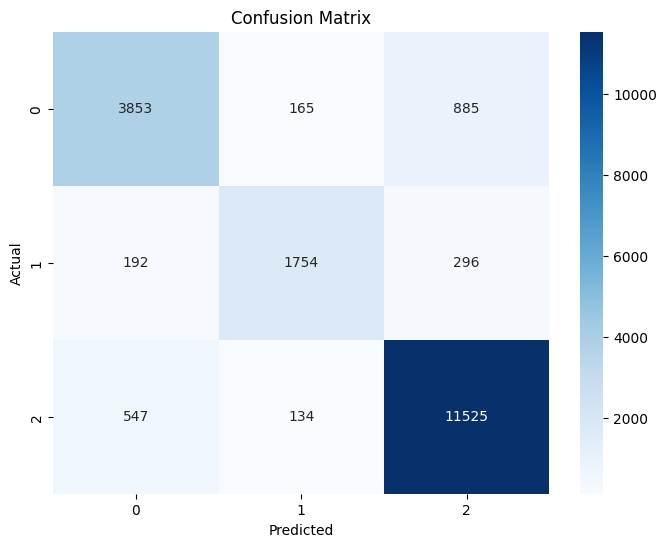

In [46]:
# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred_mlg)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=model_mlg.classes_, yticklabels=model_mlg.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### **ROC Score**

In [47]:
# ROC Score
mlg_roc_auc = roc_auc_score(y_test, y_prob_mlg, multi_class='ovr')
print(f'ROC AUC Score: {mlg_roc_auc}')

ROC AUC Score: 0.9459175641072676


### **ROC Curve**

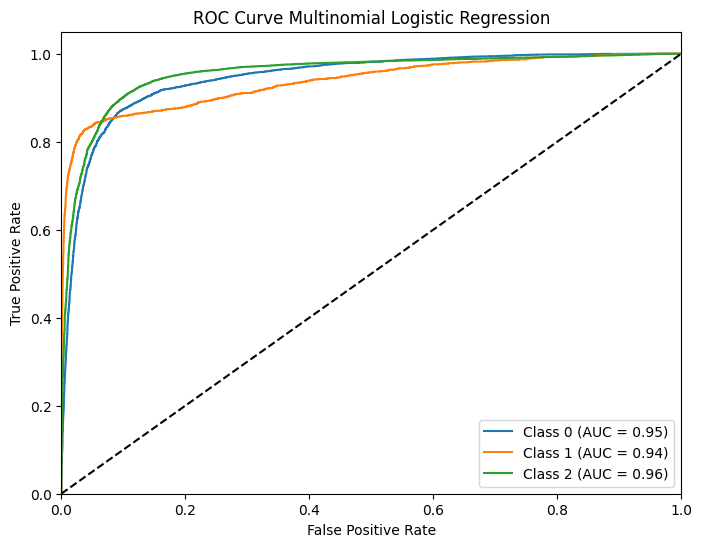

In [48]:
# ROC Curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(model_mlg.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, model_mlg.predict_proba(X_test)[:, i])  # Use predict_proba for multi-class
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(len(model_mlg.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Multinomial Logistic Regression')
plt.legend(loc="lower right")
plt.show()

### **Classification Report**

In [49]:
# Classification Report
print(classification_report(y_test, y_pred_mlg))

              precision    recall  f1-score   support

           0       0.84      0.79      0.81      4903
           1       0.85      0.78      0.82      2242
           2       0.91      0.94      0.93     12206

    accuracy                           0.89     19351
   macro avg       0.87      0.84      0.85     19351
weighted avg       0.88      0.89      0.88     19351



## **Naive Bayes Multinomial**

### **Predict**

The steps in making predictions are as follows:
- Calculate the prior probability of each class, which is the proportion of documents in that class to the total number of documents.
- Calculate the likelihood of each features (words) based on the frequency of the word in the documents of that class.
- Calculating predictions with the class that has the highest likelihood that will be selected as the prediction class.

In [50]:
# Predict
y_pred_nbm = model_nbm.predict(X_test)
y_pred_nbm

array([2, 2, 2, ..., 2, 2, 2])

### **Probability**

In [51]:
# Probability
y_prob_nbm = model_nbm.predict_proba(X_test)
print(y_prob_nbm)

[[0.07248872 0.00538709 0.92212418]
 [0.19736047 0.02725417 0.77538535]
 [0.16836555 0.03683953 0.79479492]
 ...
 [0.0319545  0.00854076 0.95950474]
 [0.03683878 0.00426625 0.95889496]
 [0.13109839 0.04955399 0.81934762]]


### **Evaluation Metric**

In [52]:
# Evaluation Metric
print(f'Accuracy: {accuracy_score(y_test, y_pred_nbm)}')
print(f'Precision: {precision_score(y_test, y_pred_nbm, average="weighted")}')
print(f'Recall: {recall_score(y_test, y_pred_nbm, average="weighted")}')
print(f'F1-Score: {f1_score(y_test, y_pred_nbm, average="weighted")}')

Accuracy: 0.6940726577437859
Precision: 0.7150985457067591
Recall: 0.6940726577437859
F1-Score: 0.6192474150121431


### **Confusion Matrix**

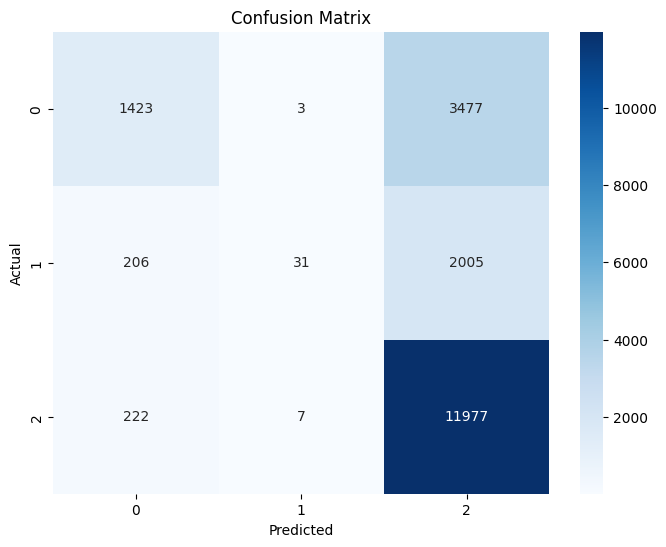

In [53]:
# Confusion Matrix
con_mat = confusion_matrix(y_test, y_pred_nbm)
plt.figure(figsize=(8, 6))
sns.heatmap(con_mat, annot=True, fmt='d', cmap='Blues', xticklabels=model_nbm.classes_, yticklabels=model_nbm.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### **ROC Score**

In [54]:
# ROC Score
nbm_roc_auc = roc_auc_score(y_test, y_prob_nbm, multi_class='ovr')
print(f'ROC AUC Score: {nbm_roc_auc}')

ROC AUC Score: 0.8606817047663116


### **ROC Curve**

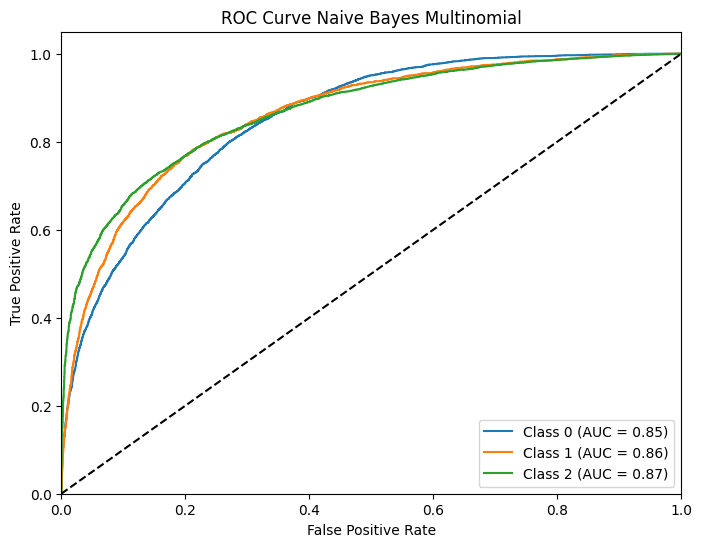

In [55]:
# ROC Curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(model_nbm.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, model_nbm.predict_proba(X_test)[:, i])  # Use predict_proba for multi-class
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve
plt.figure(figsize=(8, 6))
for i in range(len(model_nbm.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Naive Bayes Multinomial')
plt.legend(loc="lower right")
plt.show()

### **Classification Report**

In [56]:
# Classification Report
print(classification_report(y_test, y_pred_nbm))

              precision    recall  f1-score   support

           0       0.77      0.29      0.42      4903
           1       0.76      0.01      0.03      2242
           2       0.69      0.98      0.81     12206

    accuracy                           0.69     19351
   macro avg       0.74      0.43      0.42     19351
weighted avg       0.72      0.69      0.62     19351



## **Score Comparison**

In [57]:
score_comparison = pd.DataFrame({'Model': ['Multinomial Logistic Regression', 'Naive Bayes Multinomial'],
                                'Accuracy': [accuracy_score(y_test, y_pred_mlg), accuracy_score(y_test, y_pred_nbm)],
                                'Precision': [precision_score(y_test, y_pred_mlg, average="weighted"), precision_score(y_test, y_pred_nbm, average="weighted"),],
                                'Recall': [recall_score(y_test, y_pred_mlg, average="weighted"), recall_score(y_test, y_pred_nbm, average="weighted")],
                                'F1-Score': [f1_score(y_test, y_pred_mlg, average="weighted"), f1_score(y_test, y_pred_nbm, average="weighted")],
                                'ROC AUC Score': [mlg_roc_auc, nbm_roc_auc]})
score_comparison

,Model,Accuracy,Precision,Recall,F1-Score,ROC AUC Score
0,Multinomial Logistic Regression,0.885329,0.883722,0.885329,0.883886,0.945918
1,Naive Bayes Multinomial,0.694073,0.715099,0.694073,0.619247,0.860682
